# Projet 5 - Segmentez des clients d'un site e-commerce

Le but de ce projet est de proposer une segmentation client d'une plateforme de commerce en ligne. Ce premier notebook consiste en le nettoyage si besoin,et l'analyse exploratoire du jeu de données. A l'issue de celui nous aurons construit le jeu de données qui servira au clustering dans la deuxième partie de ce projet.

Le dataset est disponible à l'adresse suivante:
https://www.kaggle.com/olistbr/brazilian-ecommerce

- cleaning
- choix des variables
- création du dataset
- RFM

In [1]:
# Import des librairies
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn import decomposition
from functools import reduce
import time
import random

# Version des modules
print('Pandas:', pd.__version__)
print('Matplotlib:', matplotlib.__version__)
print('Numpy:', np.__version__)
print('Seaborn:', sns.__version__)
print('Scikit-learn:', sklearn.__version__)

Pandas: 1.0.5
Matplotlib: 3.2.2
Numpy: 1.19.5
Seaborn: 0.11.1
Scikit-learn: 0.23.1


In [2]:
# On renseigne une valeur de random seed de façon 
# à ce que le notebook soit reproductible
random.seed(10)

# Thème seaborn
sns.set(style='ticks', font_scale=1.4)

In [3]:
# Chargement des datasets
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
product_category_name_translation = pd.read_csv('product_category_name_translation.csv')

Commençons par prendre connaissance de nos données:

In [4]:
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [5]:
geolocation.head(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP


In [6]:
orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [7]:
orders.groupby(by='order_status').size()

order_status
approved           2
canceled         625
created            5
delivered      96478
invoiced         314
processing       301
shipped         1107
unavailable      609
dtype: int64

In [8]:
# On ne garde que les commandes ayant abouti
canceled_orders = orders[orders['order_status']=='canceled']
orders = orders[orders['order_status']=='delivered']

In [9]:
# Liste des commances annulées
orders_canceled = canceled_orders['order_id']

Plusieurs pistes de réfléxion:
- l'objet n'est jamais arrivé / délai de livraison trop long
- l'objet était de mauvaise qualité
- un mauvais vendeur

In [10]:
list_item_can = order_items[order_items['order_id'].isin(orders_canceled)]
list_item_can

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
84,00310b0c75bb13015ec4d82d341865a4,1,c8e7c2ef329fcda4a233e7e2f8bb8b7d,a2deecd5398f5df4987110c80a1972a3,2018-08-17 15:04:25,39.90,15.38
270,00ae7a8b4936674ebb701d4a23719a79,1,66f09a6de4f2ef63aaf5349b60a0e0c0,bf0d50a6410d487dc97d2baac0a8c0be,2018-05-15 15:51:32,27.90,9.26
422,00ff0cf5583758e6964723e42f111bf4,1,bb1fe952bdc16ef8974d4ca11aec19b7,b17b679f4f5ce2e03ce6968c62648246,2017-04-14 01:03:29,154.90,15.25
543,013e9c654a339d80b53513da3c1ea437,1,bcac2cdcd851929a5caa3e1508d5abc9,0adac9fbd9a2b63cccaac4f8756c1ca8,2017-06-22 13:55:18,109.90,13.11
558,0148d3df00cebda592d4e5f966e300cc,1,ed08ea04c92f5f434c2362f7310fb328,0adac9fbd9a2b63cccaac4f8756c1ca8,2017-08-24 19:24:32,5.53,11.85
...,...,...,...,...,...,...,...
110535,fb265b2dc558a56445dfc48f8224e201,1,baf25ed4f8f70238cc87230379471454,128f9bfbe4c7d5185033914b1de3d39a,2017-10-18 21:35:15,9.90,121.22
111019,fc3c882665c98c9b737a7b1b3aa6c553,1,44aadbb26d5c81d9846b0c48bc00d7a3,2528513dd95219a6013d4d05176e391a,2018-04-23 18:55:18,28.90,8.88
111703,fdbbb1715d0c62c714e2a8178b95dd54,1,1b43b0a6105ffaa6dae01356daec2657,cc419e0650a3c5ba77189a1882b7556a,2018-05-22 21:50:38,57.99,11.15
112073,fe9aa3b22b4d65ccbaffb57984bc12fb,1,e71589252b1fc69c5a7931ee5028ecf6,0432ead42b6c8a0bdf68154add917fdf,2017-11-21 19:50:28,39.90,7.78


In [11]:
# Liste des 10 produits les plus souvent annulés
list_item_can = list_item_can.groupby(by='product_id').size().sort_values(ascending=False)
list_item_can.head(10)

product_id
5c3eaf54e8ee5d5378765ff16df7640b    6
8397dc503d1a0c2ac7422701884de5a6    6
1c42962612d557f85753b24c2b97070f    5
99b4367cf2228c8a86922a0649bee6b8    5
75f3ef6a5cb0f2d5aeef15925f0ccf69    5
66b1f09e746c05761bcaccf6339bde8d    5
3ea32f63a6aaf8d467e543dedf434ee7    5
c3a52053718435a35e070b991ff546ec    5
ed08ea04c92f5f434c2362f7310fb328    5
7d4f932dd4fa16256c20de073329eacc    5
dtype: int64

In [12]:
# Commandes
order_items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [13]:
# Paiments
order_payments.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71


In [14]:
# Avis et notes
order_reviews.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24


In [15]:
#Produits
products.head(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


In [16]:
# Vendeurs
sellers.head(3)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ


In [17]:
# Traduction anglaise des catégories
product_category_name_translation.head(3)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto


Commençons par nous assurer que nous n'avons pas de doublons là où il ne devrait pas y en avoir:

In [18]:
# Fonction qui renvoit le nom du dataframe utilisé
def get_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [19]:
def doublon(df, column, return_doublons=False):
    "Affiche les doublons d'un dataframe ou renvoit l'index si demandé"
    doubl = df.groupby(by=column).size()
    doubl = doubl[doubl!=1]   
    if return_doublons == True:
        return doubl.index
    else:  
        l = len(doubl)
        s = doubl.sum()
        if s > 0:
            print(f'{get_name(df)} contient {l} doublons pour la variable {column} sur les valeurs {doubl.index}.')
        else:
            print(f'{get_name(df)} ne contient pas de doublons sur la variable {column}.')

In [20]:
doublon(orders, 'order_id')

orders ne contient pas de doublons sur la variable order_id.


In [21]:
doublon(customers, 'customer_id')
doublon(customers, 'customer_unique_id')

customers ne contient pas de doublons sur la variable customer_id.
customers contient 2997 doublons pour la variable customer_unique_id sur les valeurs Index(['00172711b30d52eea8b313a7f2cced02', '004288347e5e88a27ded2bb23747066c',
       '004b45ec5c64187465168251cd1c9c2f', '0058f300f57d7b93c477a131a59b36c3',
       '00a39521eb40f7012db50455bf083460', '00cc12a6d8b578b8ebd21ea4e2ae8b27',
       '011575986092c30523ecb71ff10cb473', '011b4adcd54683b480c4d841250a987f',
       '012452d40dafae4df401bced74cdb490', '012a218df8995d3ec3bb221828360c86',
       ...
       'fe81bb32c243a86b2f86fbf053fe6140', 'fed2005ccab4fcf1a40ebdaff032a148',
       'fed519569d16e690df6f89cb99d4e682', 'ff03923ad1eb9e32304deb7f9b2a45c9',
       'ff22e30958c13ffe219db7d711e8f564', 'ff36be26206fffe1eb37afd54c70e18b',
       'ff44401d0d8f5b9c54a47374eb48c1b8', 'ff8892f7c26aa0446da53d01b18df463',
       'ff922bdd6bafcdf99cb90d7f39cea5b3', 'ffe254cc039740e17dd15a5305035928'],
      dtype='object', name='customer_unique_id

Les variables **customer_id** et **customer_unique_id** sont un peu ambigües. On remarque qu'il y a une correspondance un pour un entre les variables **customer_id** et **order_id**. 

Puisqu'on peut raisonnablement penser qu'au moins un utilisateur a passé plusieurs commandes sur le site, les clients sont logiquement identifiés avec la variable **customer_unique_id**.

In [22]:
2997/customers['customer_unique_id'].nunique()

0.031187562437562436

Seulement 3% des clients ont commandé plusieurs fois sur le site.

Nos datasets contiennent-ils beaucoup de valeurs manquantes?

In [23]:
liste_df = [customers,
           geolocation,
           orders,
           order_items,
           order_payments,
           order_reviews,
           products,
           sellers,
           product_category_name_translation]

In [24]:
for df in liste_df:
    print(f'{get_name(df)}:')
    print(df.info())
    print('\n')

customers:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None


geolocation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city

On voit que globalement les datasets sont très bien remplis.

Pour le dataframe 'products', certaines catégories ne sont pas renseignées, on supprime les lignes correspondantes.

Pour le dataframe 'orders', nous n'avons sélectionné que les commandes ayant été livrées, il ne devrait donc pas y avoir de valeurs manquantes sur les dates; voyons les lignes correspondantes:

In [25]:
orders[orders.isna().any(axis=1)]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaN,2017-12-18 00:00:00
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaN,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17 00:00:00
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaN,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21 00:00:00
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaN,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17 00:00:00
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaN,2018-07-16 00:00:00
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaN,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31 00:00:00
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaN,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20 00:00:00
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaN,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01 00:00:00
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaN,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27 00:00:00
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaN,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22 00:00:00


Il semble il y avoir parfois un bug entre la date d'approbation de la commande et la date de livraison, on supprime simplement le tout, et on le fera remonter aux développeurs du site.

In [26]:
orders = orders.dropna()
products = products.dropna()

Les jeux de données étant très propres, le nettoyage s'arrête là.

## Analyse exploratoire

In [27]:
def tracer_distrib(df):
    """
    Fonction permettant de représenter la distribution des colonnes d'un dataframe
    """
    df = df.select_dtypes(include=np.number)
    n_feat = df.shape[1]
    if n_feat == 0:
        return
    elif n_feat % 4 == 0:
        n_row = int(n_feat/4)
    else:
        n_row = int(n_feat/4) + 1
   
    fig = plt.figure(figsize=(16, n_row*4))
    for feat_idx in range(n_feat):
        ax = fig.add_subplot(n_row, 4, (feat_idx+1))
        h = ax.hist(df.iloc[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
        name = df.columns[feat_idx] + '\n'
        ax.set_title(name, fontsize=14)
    plt.show()

In [28]:
liste_df = [customers,
           geolocation,
           orders,
           order_items,
           order_payments,
           order_reviews,
           products,
           sellers,
           product_category_name_translation]

customers
:


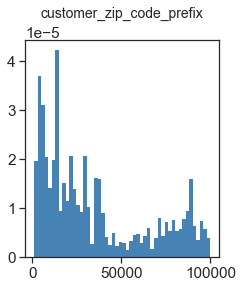

geolocation
:


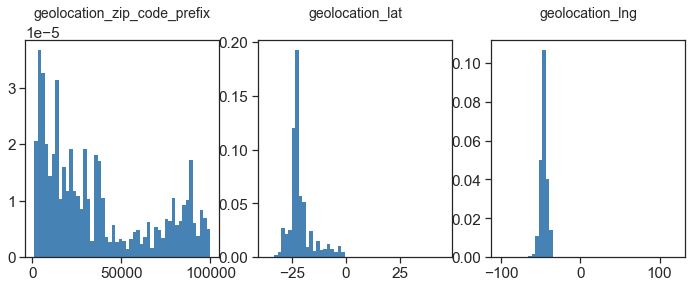

orders
:
order_items
:


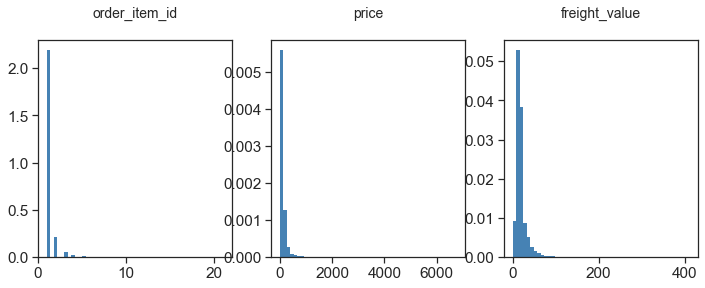

order_payments
:


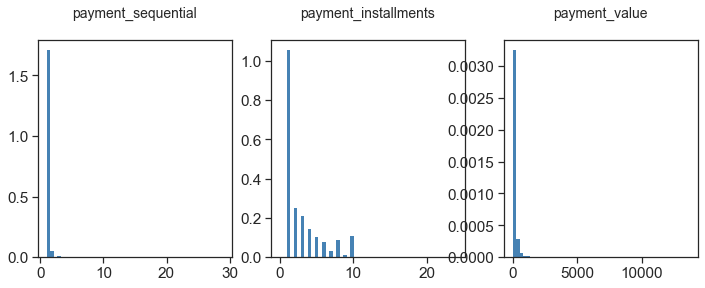

order_reviews
:


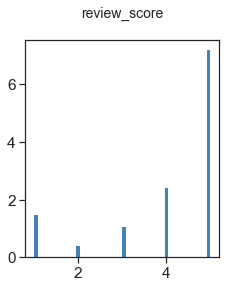

products
:


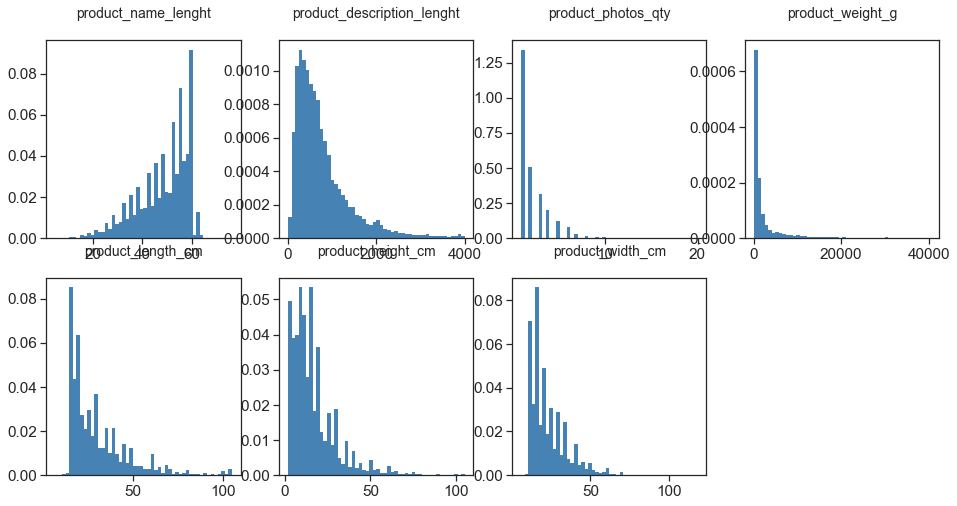

sellers
:


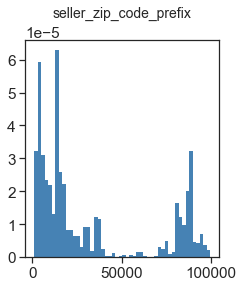

product_category_name_translation
:


In [29]:
for df in liste_df:
    print(f'{get_name(df)}\n:')
    tracer_distrib(df)

In [30]:
def tracer_boxplot(df):
    """
    Fonction permettant de représenter le boxplot des colonnes d'un dataframe
    """
    df = df.select_dtypes(include=np.number)
    n_feat = df.shape[1]
    if n_feat == 0:
        return
    elif n_feat % 4 == 0:
        n_row = int(n_feat/4)
    else:
        n_row = int(n_feat/4) + 1
    
    fig = plt.figure(figsize=(16, n_row*4))
    for feat_idx in range(n_feat):
        data = df.iloc[:, feat_idx]
        ax = fig.add_subplot(n_row, 4, (feat_idx+1))
        h = ax.boxplot(data[~np.isnan(data)])

        ax.set_title(df.columns[feat_idx], fontsize=14)

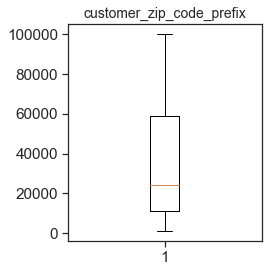

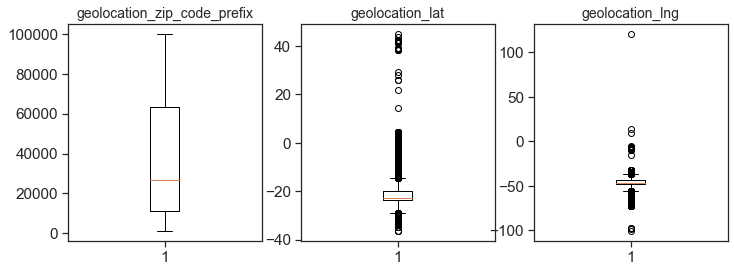

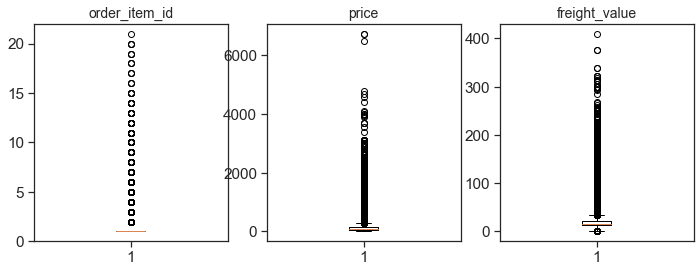

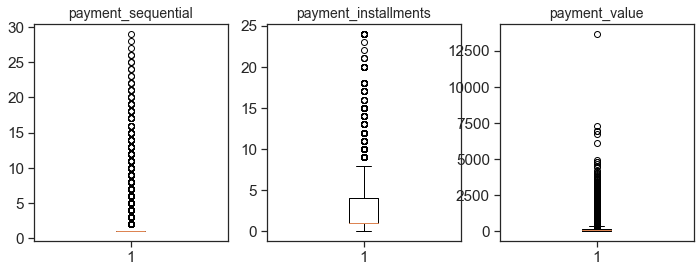

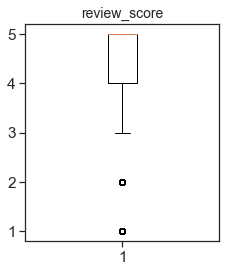

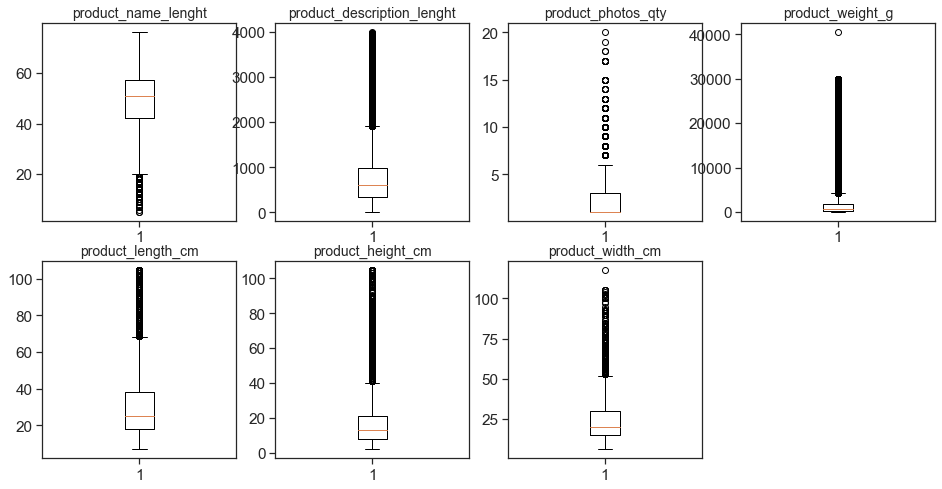

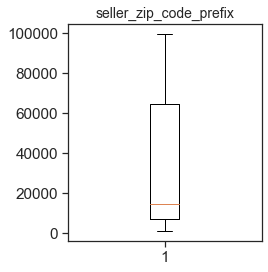

In [31]:
for df in liste_df:
    tracer_boxplot(df)

## Création du dataframe

Nous allons maintenant créer le DataFrame sur lequel nous testerons nos différents modèles de clustering. 

**Variables à créer**:

Nous appliquerons la méthode RFM (Récence, Fréquence, Montant), classiquement utilisée en segmentation client:

- Récence: nombre de jours depuis le dernier achat
- Fréquence: nombre d'achat sur la période étudiée
- Montant: valeur totale des achats

Nous créerons également deux autres variables:
- Délai de livraison: nombre de jours entre l'achat et la réception du colis
- Retard de livraison: nombre de jours de reatrd (ou d'avance si négatif) par rapport à la date estimée

**Variables à encoder**:

Nous encoderons les variables suivantes avec un encodage de type "one hot encoder".
- Etat de résidence du client
- Catégorie d'objet

**Autres variables**:
- review_score: moyenne des notes des avis d'un client client
- payment_installments: en combien de fois le client a réglé en moyenne

In [32]:
# Conversion en dates
for feat in ['order_purchase_timestamp',
            'order_approved_at', 
            'order_delivered_carrier_date',
            'order_delivered_customer_date', 
            'order_estimated_delivery_date']:   
    orders.loc[:,feat] = pd.to_datetime(orders[feat])

In [33]:
# Période totale
first_day = orders['order_purchase_timestamp'].min()
last_day = orders['order_purchase_timestamp'].max()
print(f'Les données vont du {first_day} au {last_day}.')

Les données vont du 2016-09-15 12:16:38 au 2018-08-29 15:00:37.


### Sélection des features
#### Score par commande

In [34]:
# Score par commande:
# Nombre de reviews par commande
order_reviews.groupby(by='order_id')['review_id'].size().sort_values(ascending=False).head()

order_id
c88b1d1b157a9999ce368f218a407141    3
8e17072ec97ce29f0e1f111e598b0c85    3
03c939fd7fd3b38f8485a0f95798f1f6    3
df56136b8031ecd28e200bb18e6ddb2e    3
241ed1aad96c4cc788ee6f8ab96242ef    2
Name: review_id, dtype: int64

On voit qu'il peut y avoir pluseurs avis par commande. Cela vient du fait qu'il est probablement possible d'éditer son avis une fois publié, qui s'enregistre alors comme un nouvel avis pour la même commande. Dans ce cas on prend la note attribuée au dernier avis en date.

In [35]:
order_reviews = order_reviews.sort_values(by=['order_id', 'review_creation_date'])
order_reviews = order_reviews.groupby('order_id').last().reset_index()
order_reviews = order_reviews[['order_id','review_score']]
order_reviews.head(3)

,order_id,review_score
0,00010242fe8c5a6d1ba2dd792cb16214,5
1,00018f77f2f0320c557190d7a144bdd3,4
2,000229ec398224ef6ca0657da4fc703e,5


#### Payments installments
Cette variable correspond en combien de fois l'achat a été effectué. On garde également le montant, qui nous sera utile.

In [36]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [37]:
aggregations = {
    'payment_installments': 'max',  # on garde le max (en combien de fois a payé le client)
    'payment_value': 'sum'          # on en fait la somme pour trouver le montant total de la commande
}

# Groupby sur la variable 'order_id'
order_payments = order_payments.groupby('order_id').agg(aggregations).reset_index()
# order_payments.columns = [['order_id', 'Nombre_paiements', 'Montant']]
order_payments.head(3)

,order_id,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,2,72.19
1,00018f77f2f0320c557190d7a144bdd3,3,259.83
2,000229ec398224ef6ca0657da4fc703e,5,216.87


### Variables catégorielles
#### Création de catégories plus larges

In [38]:
products['product_category_name'].nunique()

73

Nous avons initialement 73 catégories différentes d'objets, ce qui est un peu trop élevé dans notre optique de clustering. Malheureusement les caractéristiques descriptives de chaque objet (nombre de photos, longueur, poids, etc...) ne permettent pas de faire un clustering efficace sur les produits. Nous allons donc regrouper à la main les catégories qui se ressemblent le plus de façon à réduire leur nombre.

In [39]:
# On ajoute les traductions en anglais
products = products.merge(product_category_name_translation)

In [40]:
# On voit que certaines catégories sont proches
liste_categories = products.groupby(by='product_category_name_english').size().sort_values(ascending=False)
liste_categories.head(15)

product_category_name_english
bed_bath_table              3029
sports_leisure              2867
furniture_decor             2657
health_beauty               2444
housewares                  2335
auto                        1900
computers_accessories       1639
toys                        1411
watches_gifts               1329
telephony                   1134
baby                         918
perfumery                    868
stationery                   849
fashion_bags_accessories     849
cool_stuff                   789
dtype: int64

In [41]:
# Dictionnaire des correspondances (fait à la main)
dict_categories = {'bed_bath_table' : 'maison', 
                  'sports_leisure': 'sport', 
                  'furniture_decor' : 'maison', 
                  'health_beauty' : 'produits_beaute',
       'housewares' : 'maison', 
       'auto' : 'automobile', 
       'computers_accessories' : 'informatique', 
       'toys' : 'jouets', 
       'watches_gifts' : 'mode',
       'telephony' : 'informatique', 
       'baby' : 'bebe', 
       'perfumery' : 'produits_beaute', 
       'stationery' : 'bureau',
       'fashion_bags_accessories' : 'mode', 
       'cool_stuff' : 'cool_stuff', 
       'garden_tools' : 'bricolage', 
       'pet_shop' : 'animaux',
       'electronics' : 'informatique', 
       'construction_tools_construction' : 'bricolage', 
       'home_appliances' : 'maison',
       'luggage_accessories' : 'automobile', 
       'consoles_games' : 'informatique', 
       'office_furniture' : 'bureau',
       'musical_instruments'  : 'divertissement', 
       'small_appliances' : 'maison', 
       'home_construction' : 'bricolage',
       'books_general_interest' : 'divertissement', 
       'fashion_shoes' : 'mode', 
       'furniture_living_room' : 'maison',
       'air_conditioning' : 'maison', 
       'books_technical' : 'divertissement', 
       'fixed_telephony' : 'informatique',
       'home_confort' : 'maison', 
       'market_place' : 'industriel', 
       'food_drink' : 'alimentation', 
       'fashion_male_clothing' : 'mode',
       'kitchen_dining_laundry_garden_furniture' : 'maison', 
       'signaling_and_security' : 'bricolage',
       'construction_tools_safety' : 'bricolage', 
       'home_appliances_2' : 'maison',
       'costruction_tools_garden' : 'bricolage', 
       'food' : 'alimentation', 
       'drinks' : 'alimentation',
       'construction_tools_lights' : 'bricolage', 
       'agro_industry_and_commerce' : 'industriel',
       'industry_commerce_and_business' : 'industriel', 
       'christmas_supplies' : 'maison', 
       'audio' : 'informatique', 
       'art' : 'divertissement',
       'fashion_underwear_beach' : 'mode', 
       'dvds_blu_ray' : 'divertissement', 
       'furniture_bedroom' : 'maison',
       'costruction_tools_tools' : 'bricolage', 
       'books_imported' : 'divertissement',
       'small_appliances_home_oven_and_coffee' : 'maison', 
       'computers' : 'informatique', 
       'cine_photo' : 'divertissement',
       'fashio_female_clothing' : 'mode', 
       'music' : 'divertissement', 
       'party_supplies' : 'maison',
       'arts_and_craftmanship' : 'bricolage', 
       'fashion_sport' : 'mode', 
       'flowers' : 'maison',
       'diapers_and_hygiene' : 'bebe', 
       'la_cuisine' : 'maison',
       'furniture_mattress_and_upholstery' : 'maison', 
       'tablets_printing_image' : 'informatique',
       'fashion_childrens_clothes' : 'mode', 
       'home_comfort_2' : 'maison', 
       'security_and_services' : 'services',
       'cds_dvds_musicals' : 'divertissement'}

In [42]:
# On ajoute les nouvelles catégories 
products['categories'] = products['product_category_name_english'].replace(dict_categories)

In [43]:
# Suppression des variables inutiles
products = products[['product_id', 'categories']]
products.head(3)

,product_id,categories
0,1e9e8ef04dbcff4541ed26657ea517e5,produits_beaute
1,6a2fb4dd53d2cdb88e0432f1284a004c,produits_beaute
2,0d009643171aee696f4733340bc2fdd0,produits_beaute


In [44]:
# Les catégories peuvent maintenant être ajoutées aux ordres
order_items = order_items.merge(products)
order_items = order_items[['order_id', 'categories']]
# Encodage de la variable "categories"
order_items = pd.get_dummies(order_items, columns=['categories'])
# Un ordre peut contenir plusieurs objets et donc plusieurs catégories:
order_items = order_items.groupby('order_id').sum().reset_index()
order_items.head(3)

,order_id,categories_alimentation,categories_animaux,categories_automobile,categories_bebe,categories_bricolage,categories_bureau,categories_cool_stuff,categories_divertissement,categories_industriel,categories_informatique,categories_jouets,categories_maison,categories_mode,categories_produits_beaute,categories_services,categories_sport
0,00010242fe8c5a6d1ba2dd792cb16214,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,00018f77f2f0320c557190d7a144bdd3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,000229ec398224ef6ca0657da4fc703e,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


#### Quelles catégories sont les plus vendues?

<ipython-input-45-d2cdb7a6f5e4>:8: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(categories, labels=categories.index)


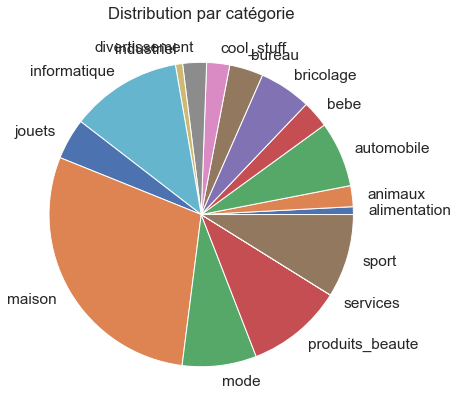

In [45]:
categories = liste_categories.reset_index()
categories['categories'] =categories['product_category_name_english'].replace(dict_categories)
categories = categories.drop(columns='product_category_name_english')
categories = categories.groupby(by='categories').sum()

plt.figure(figsize=(15, 7))
plt.title('Distribution par catégorie')
plt.pie(categories, labels=categories.index)
plt.show()


#### Etats de résidence

In [46]:
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [47]:
customer_state = customers.groupby(by='customer_state').size()
customer_state = customer_state.sort_values(ascending=False)

In [48]:
# Encodage des états de résidence par client
# customers = customers.groupby(by='customer_unique_id')['customer_state'].first()
customers = pd.get_dummies(customers, columns=['customer_state'])
customers = customers.drop(columns = ['customer_zip_code_prefix', 'customer_city'])
customers.head(3)

,customer_id,customer_unique_id,customer_state_AC,customer_state_AL,customer_state_AM,customer_state_AP,customer_state_BA,customer_state_CE,customer_state_DF,customer_state_ES,...,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


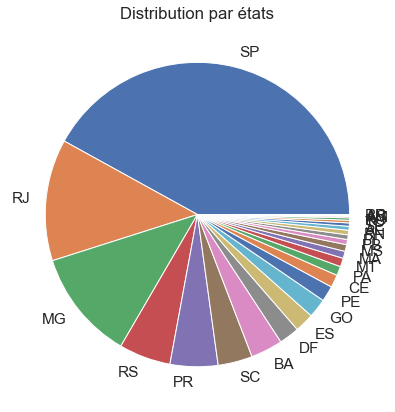

In [49]:
plt.figure(figsize=(15, 7))
plt.title('Distribution par états')
plt.pie(customer_state, labels=customer_state.index)
plt.show()

### Nouvelles features
#### Délai de livraison, retard par rapport au délai prévu

In [50]:
# Création des deux nouvelles variables
orders['delai_livraison'] = orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']
orders['delai_livraison'] = orders['delai_livraison'].dt.days
orders['retard_livraison'] = orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']
orders['retard_livraison'] = orders['retard_livraison'].dt.days

In [51]:
# Suppression des variables inutiles sur 'orders'
orders = orders[['order_id',
                 'customer_id',
                'order_purchase_timestamp',
                'delai_livraison', 
                'retard_livraison']]
orders.head(3)

,order_id,customer_id,order_purchase_timestamp,delai_livraison,retard_livraison
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,8,-8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,13,-6
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,9,-18


Les variables 'délai' et 'retard' de livraison sont exprimées en jour. Une valeur négative sur le retard signifie que le colis est arrivé en avance d'autant de jours, par rapport à la date estimée communiquée au client.

#### Regroupement de toutes les variables
On commence par réaliser un 'merge' de tous les dataframes sur la variable 'order_id':

In [52]:
dataframes = [orders, order_reviews, order_payments, order_items]

In [53]:
orders.dtypes

order_id                            object
customer_id                         object
order_purchase_timestamp    datetime64[ns]
delai_livraison                      int64
retard_livraison                     int64
dtype: object

In [54]:
order_payments.dtypes

order_id                 object
payment_installments      int64
payment_value           float64
dtype: object

In [55]:
for df in dataframes:
    doublon(df, 'order_id')

orders ne contient pas de doublons sur la variable order_id.
order_reviews ne contient pas de doublons sur la variable order_id.
order_payments ne contient pas de doublons sur la variable order_id.
order_items ne contient pas de doublons sur la variable order_id.


In [56]:
data = reduce(lambda left, right: pd.merge(left, right, on='order_id'), dataframes)
data

,order_id,customer_id,order_purchase_timestamp,delai_livraison,retard_livraison,review_score,payment_installments,payment_value,categories_alimentation,categories_animaux,...,categories_cool_stuff,categories_divertissement,categories_industriel,categories_informatique,categories_jouets,categories_maison,categories_mode,categories_produits_beaute,categories_services,categories_sport
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,8,-8,4,1,38.71,0,0,...,0,0,0,0,0,1,0,0,0,0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,13,-6,4,1,141.46,0,0,...,0,0,0,0,0,0,0,1,0,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,9,-18,5,3,179.12,0,0,...,0,0,0,0,0,0,0,0,0,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,13,-13,5,1,72.20,0,1,...,0,0,0,0,0,0,0,0,0,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2,-10,5,1,28.62,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95098,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,8,-11,5,3,85.08,0,0,...,0,0,0,0,0,0,0,1,0,0
95099,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58,22,-2,4,3,195.00,0,0,...,0,0,0,0,0,0,0,0,0,0
95100,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43,24,-6,5,5,271.01,0,0,...,0,0,0,0,0,1,0,0,0,0
95101,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,17,-21,2,4,441.16,0,0,...,0,0,0,2,0,0,0,0,0,0


On merge ensuite avec la variable 'customer_id' de façon à rajouter les états de résidence:

In [57]:
data = data.merge(customers)

On réalise enfin un groupby sur la variable 'customer_unique_id':

In [58]:
list_mean = ['delai_livraison', 'retard_livraison', 'review_score',
       'payment_installments',]
list_sum = ['payment_value', 'categories_alimentation',
       'categories_animaux', 'categories_automobile', 'categories_bebe',
       'categories_bricolage', 'categories_bureau', 'categories_cool_stuff',
       'categories_divertissement', 'categories_industriel',
       'categories_informatique', 'categories_jouets', 'categories_maison',
       'categories_mode', 'categories_produits_beaute', 'categories_services',
       'categories_sport', 'customer_unique_id']
list_first = ['customer_state_AC',
       'customer_state_AL', 'customer_state_AM', 'customer_state_AP',
       'customer_state_BA', 'customer_state_CE', 'customer_state_DF',
       'customer_state_ES', 'customer_state_GO', 'customer_state_MA',
       'customer_state_MG', 'customer_state_MS', 'customer_state_MT',
       'customer_state_PA', 'customer_state_PB', 'customer_state_PE',
       'customer_state_PI', 'customer_state_PR', 'customer_state_RJ',
       'customer_state_RN', 'customer_state_RO', 'customer_state_RR',
       'customer_state_RS', 'customer_state_SC', 'customer_state_SE',
       'customer_state_SP', 'customer_state_TO']

In [59]:
aggregations = {
    'order_purchase_timestamp': lambda x: (last_day - x.max()).days,  
    'order_id' : 'size',
    'payment_value' : 'sum', 
    'delai_livraison' : 'mean',
    'retard_livraison' : 'mean', 
    'review_score' : 'mean',
    'payment_installments' : 'mean',
    'categories_alimentation' : 'sum',
    'categories_animaux' : 'sum', 
    'categories_automobile' : 'sum', 
    'categories_bebe' : 'sum',     
    'categories_bricolage' : 'sum', 
    'categories_bureau' : 'sum', 
    'categories_cool_stuff' : 'sum',    
    'categories_divertissement' : 'sum', 
    'categories_industriel' : 'sum',     
    'categories_informatique' : 'sum', 
    'categories_jouets' : 'sum', 
    'categories_maison' : 'sum',    
    'categories_mode' : 'sum', 
    'categories_produits_beaute' : 'sum', 
    'categories_services' : 'sum',
    'categories_sport' : 'sum', 
    'customer_state_AC' : 'first',     
    'customer_state_AL' : 'first', 
    'customer_state_AM' : 'first', 
    'customer_state_AP' : 'first',     
    'customer_state_BA' : 'first', 
    'customer_state_CE' : 'first', 
    'customer_state_DF' : 'first',   
    'customer_state_ES' : 'first', 
    'customer_state_GO' : 'first', 
    'customer_state_MA' : 'first',     
    'customer_state_MG' : 'first', 
    'customer_state_MS' : 'first', 
    'customer_state_MT' : 'first',    
    'customer_state_PA' : 'first', 
    'customer_state_PB' : 'first', 
    'customer_state_PE' : 'first',      
    'customer_state_PI' : 'first', 
    'customer_state_PR' : 'first', 
    'customer_state_RJ' : 'first',      
    'customer_state_RN' : 'first', 
    'customer_state_RO' : 'first', 
    'customer_state_RR' : 'first',     
    'customer_state_RS' : 'first', 
    'customer_state_SC' : 'first', 
    'customer_state_SE' : 'first', 
    'customer_state_SP' : 'first', 
    'customer_state_TO' : 'first'
}

# Groupby sur la variable 'order_id'
data = data.groupby('customer_unique_id').agg(aggregations).reset_index()


In [60]:
data = data.rename(columns={'order_purchase_timestamp': 'Recence', 'order_id': 'Frequence', 'payment_value':'Montant'})

In [61]:
data=data.set_index('customer_unique_id')

In [62]:
data

,Recence,Frequence,Montant,delai_livraison,retard_livraison,review_score,payment_installments,categories_alimentation,categories_animaux,categories_automobile,...,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,6.0,-5.0,5.0,8.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,3.0,-5.0,4.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
0000f46a3911fa3c0805444483337064,536,1,86.22,25.0,-2.0,3.0,8.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,20.0,-12.0,4.0,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,287,1,196.89,13.0,-8.0,5.0,6.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,446,1,2067.42,27.0,-27.0,5.0,10.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fffea47cd6d3cc0a88bd621562a9d061,261,1,84.58,30.0,-3.0,4.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ffff371b4d645b6ecea244b27531430a,567,1,112.46,14.0,-30.0,5.0,1.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [63]:
# Enregistrement au format .csv
import os
cwd = os.getcwd()
path = cwd + "/data.csv"
data.to_csv(path)